In [1]:
import pandas as pd
from pandas import DataFrame
import cPickle as pickle
from collections import defaultdict
import re

In [3]:
with open('naukri_dataframe.pkl', 'r') as f:
    naukri_df = pickle.load(f)   

In [4]:
naukri_df.head(3)

,Location,Link,Job Description,Experience,Salary,Industry,Functional Area,Role Category,Design Role,Skills,Company Name,UG,PG,Doctorate
0,Mumbai,https://www.naukri.com/job-listings-Machine-Le...,We are looking for a machine learning scientis...,3 - 4 yrs,Not Disclosed by Recruiter,IT-Software / Software Services,Analytics & Business Intelligence,Analytics & BI,Data Analyst,Machine Learning|Natural Language Processing|N...,Premium-Jobs,Any Graduate - Any Specialization,,Doctorate Not Required
1,Bengaluru,https://www.naukri.com/job-listings-Machine-Le...,Research & Development (R&D) Engineer Job des...,2 - 5 yrs,"INR 10,00,000 - 15,00,000 P.A",IT-Software / Software Services,"IT Software - Application Programming , ...",Programming & Design,Software Developer,Algorithms|Machine Learning|Python|Artificial ...,IPsoft Global Services Private Limited,B.Tech/B.E. - Computers,,
2,Bengaluru,https://www.naukri.com/job-listings-Software-E...,Work in cohesion with the R&D team towards bui...,1 - 5 yrs,Not Disclosed by Recruiter,IT-Software / Software Services,"IT Software - DBA , Datawarehousing",Programming & Design,Software Developer,R|D|Machine Learning|NLP|Software Engineering|...,Premium-Jobs,Any Graduate - Any Specialization,,Doctorate Not Required


Identify which locations have the most of ML job openings:

In [5]:
naukri_df['Location'].value_counts()[:10]

Bengaluru              626
Mumbai                 190
Hyderabad              143
Pune                    86
Delhi NCR               57
Chennai                 55
Gurgaon                 55
Delhi NCR,  Gurgaon     44
Delhi                   32
Noida                   29
Name: Location, dtype: int64

But this alone is not sufficient, since we need to put 'Delhi', 'Delhi NCR', 'Gurgaon', etc. under a single category. <br>
There are also some rows in which the locations are comma-separated like below:

In [7]:
print naukri_df.ix[499,'Location']

Delhi NCR,  Mumbai,  Bengaluru,  United States (U.S),  Singapore,  Hong Kong,  Chicago


In [8]:
uniq_locs = set()
for loc in naukri_df['Location']:
    uniq_locs = uniq_locs.union(set(loc.split(',')))
    
uniq_locs = set([item.strip() for item in uniq_locs])

In [9]:
locations_str = '|'.join(naukri_df['Location']) # All locations into a single string for pattern matchings 
loc_dict = defaultdict(int)
for loc in uniq_locs:
    loc_dict[loc] = len(re.findall(loc, locations_str))

In [10]:
# Take the top 10 most frequent job locations
jobs_by_loc = pd.Series(loc_dict).sort_values(ascending = False)[:10]

In [12]:
print jobs_by_loc

Bengaluru                756
Mumbai                   285
Delhi                    200
Hyderabad                182
Delhi NCR                148
Gurgaon                  128
Pune                     121
Chennai                   73
Noida                     43
Bengaluru / Bangalore     23
dtype: int64


Combine all the rows correponding to (1) Bengaluru (2) Delhi 

In [13]:
jobs_by_loc['Bengaluru'] = jobs_by_loc['Bengaluru'] + jobs_by_loc['Bengaluru / Bangalore'] 
jobs_by_loc['Delhi NCR'] = jobs_by_loc['Delhi NCR'] + jobs_by_loc['Delhi'] + jobs_by_loc['Noida'] + jobs_by_loc['Gurgaon'] 
jobs_by_loc.drop(['Bengaluru / Bangalore','Delhi','Noida','Gurgaon'], inplace=True)
jobs_by_loc.sort_values(ascending = False, inplace=True)
print jobs_by_loc

Bengaluru    779
Delhi NCR    519
Mumbai       285
Hyderabad    182
Pune         121
Chennai       73
dtype: int64


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

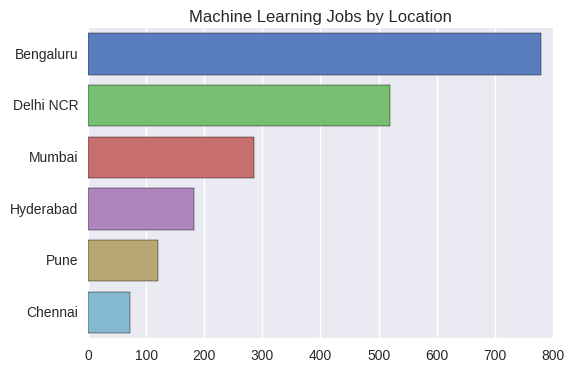

In [15]:
bar_plot = sns.barplot(y=jobs_by_loc.index,x=jobs_by_loc.values,
                        palette="muted",orient = 'h')                        
plt.title("Machine Learning Jobs by Location")
plt.show()

In [13]:
jobs_by_companies = naukri_df['Company Name'].value_counts()[:10]

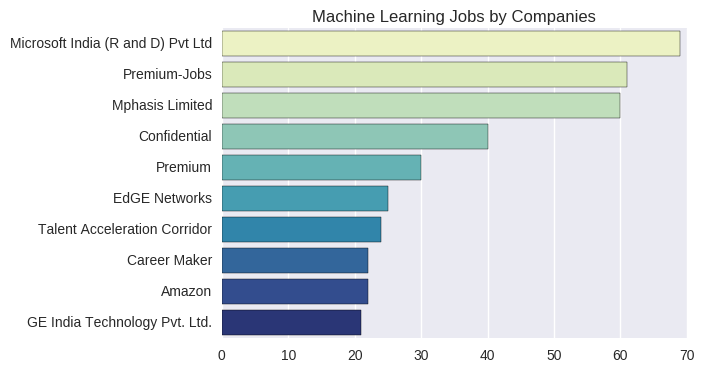

In [14]:
bar_plot = sns.barplot(y=jobs_by_companies.index,x=jobs_by_companies.values,
                        palette="YlGnBu",orient = 'h')
plt.title("Machine Learning Jobs by Companies")
plt.show()

Correlation between salary and experience:

In [16]:
salary_list = []
exp_list = []
for i in range(len(naukri_df['Salary'])):
    salary = naukri_df.ix[i, 'Salary']
    exp = naukri_df.ix[i, 'Experience']
    if 'INR' in salary:
        salary_list.append((int(re.sub(',','',salary.split("-")[0].split("  ")[1])) + int(re.sub(',','',salary.split("-")[1].split(" ")[1])))/2.0)
        exp_list.append((int(exp.split("-")[0]) + int(exp.split("-")[1].split(" ")[1]))/2.0)
    i+=1

In [17]:
plot_data = pd.DataFrame({'Experience':exp_list,'Salary':salary_list})

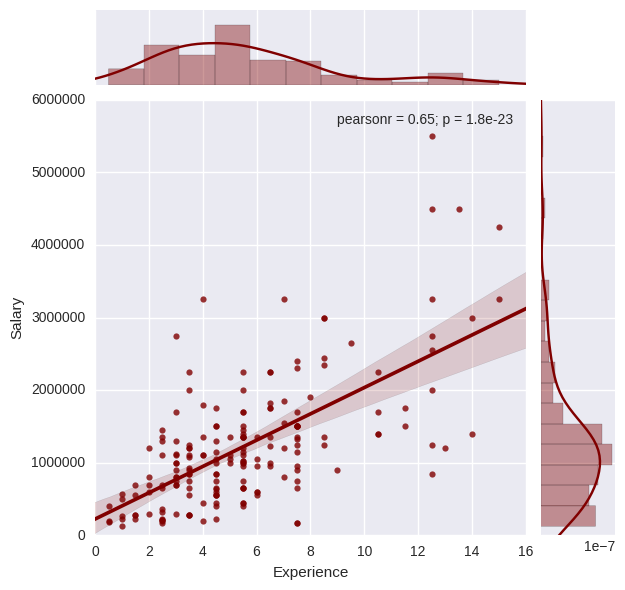

In [18]:
sns.jointplot(x = 'Experience', y = 'Salary', data=plot_data, kind='reg', color='maroon')
plt.ylim((0,6000000))
plt.xlim((0,16))
plt.show()

Which PhD specializations have most demand for a data-science role?

In [19]:
import nltk
from nltk.tokenize import word_tokenize

In [20]:
from collections import Counter

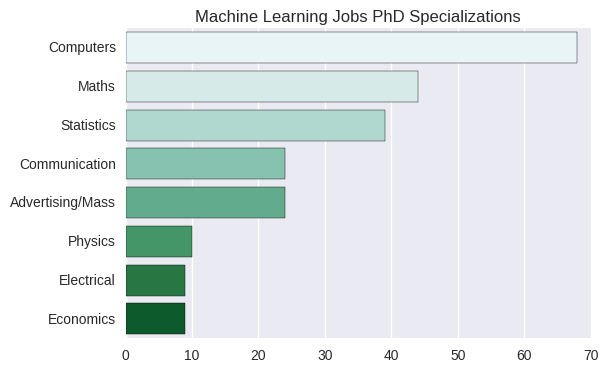

In [21]:
tokens = [word_tokenize(item) for item in naukri_df['Doctorate'] if 'Ph.D' in item]
jobs_by_phd = pd.Series(Counter([item for sublist in tokens for item in sublist if len(item) > 4])).sort_values(ascending = False)[:8]
bar_plot = sns.barplot(y=jobs_by_phd.index,x=jobs_by_phd.values,
                        palette="BuGn",orient = 'h')
plt.title("Machine Learning Jobs PhD Specializations")
plt.show()

Skills required for the job (Bar chart):

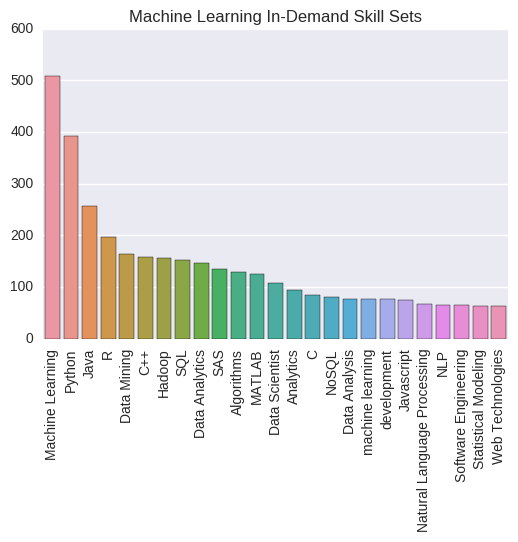

In [23]:
skills = pd.Series(Counter('|'.join(naukri_df['Skills']).split('|'))).sort_values(ascending = False)[:25]
sns.color_palette("OrRd", 10)
bar_plot = sns.barplot(y=skills.values,x=skills.index,orient = 'v')
plt.xticks(rotation=90)
plt.title("Machine Learning In-Demand Skill Sets")
plt.show()

Word cloud from Job Descriptions

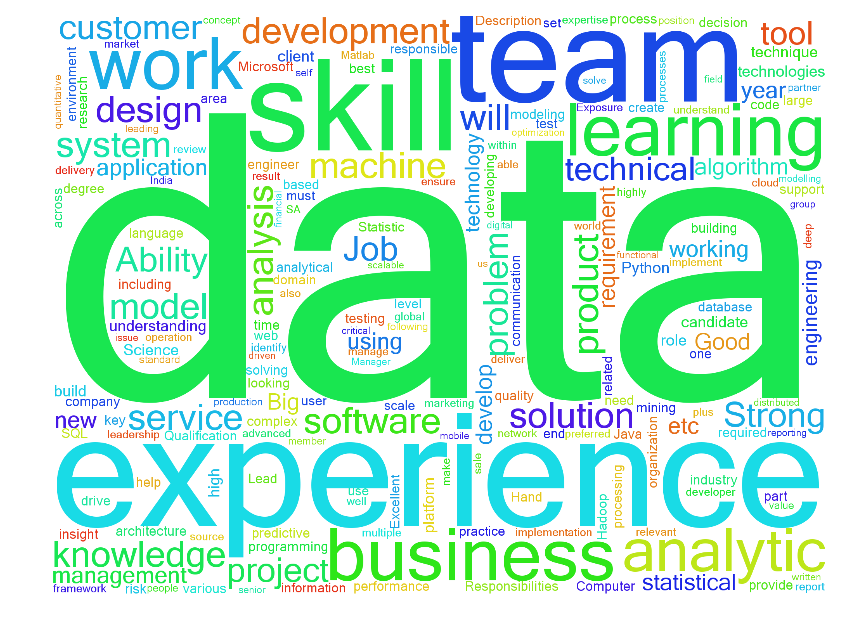

In [24]:
from wordcloud import WordCloud, STOPWORDS

jd_string = ' '.join(naukri_df['Job Description'])

wordcloud = WordCloud(font_path='/home/hareesh/Github/naukri-web-scraping/Microsoft_Sans_Serif.ttf',
                          stopwords=STOPWORDS,background_color='white', height = 1500, width = 2000).generate(jd_string)

plt.figure(figsize=(10,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()